In [1]:
# import necessary libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

# BigQuery settings
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
# ignore if local tmp.csv already exists
# read the time matching CSV and remove MRNs for security reasons (ignore if local tmp.csv already exists)
import pandas as pd
data_frame = pd.read_csv('jon_mapping.csv')
data_frame = data_frame.drop('MRN', axis = 1) 
data_frame.to_csv('tmp.csv', index = False)

In [ ]:
# only for testing
# Generate a random mapping (CSV file) to test (only for testing)

import pandas as pd
data_frame = pd.read_csv('tmp.csv')
print(list(data_frame.columns)) # print the column names

num_row = data_frame.shape[0]
print(num_row) # print num_row

data_frame = data_frame.drop('JITTER', axis = 1) # remove a column

data_frame['JITTER_test']= np.random.randint(10, size=num_row) # add a column 

print(data_frame[0:10]) # print the first 10 rows

data_frame.to_csv('tmp_rnd_shift.csv', index = False) # save to CSV

## Read from cohort_v2 from BigQuery to numpy

In [4]:
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
query = "select jc_uid, pat_enc_csn_id_coded, t2tpa from `noshad.cohort_v2`"; # Example dataset table
cursor.execute(query);
results = cursor.fetchall();

A = np.array(results)
print(A.shape)
print(A[0,:])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


(264, 3)
['JCcd691a' '131018562095' '39']


## Read from clinical_event_time from BigQuery to numpy

In [6]:
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
query = """ 
Select
DATETIME_DIFF(inpatientAdmitTime,emergencyAdmitTime, MINUTE) as t2inpatient,
DATETIME_DIFF(LabOrderTime,emergencyAdmitTime, MINUTE) as t2labOrder,
DATETIME_DIFF(LabResultTime,emergencyAdmitTime, MINUTE) as t2labResult,
DATETIME_DIFF(ctHeadOrderTime,emergencyAdmitTime, MINUTE) as t2CTorder,
DATETIME_DIFF(ctHeadResult,emergencyAdmitTime, MINUTE) as t2CTresult,
DATETIME_DIFF(tpaOrderTime,emergencyAdmitTime, MINUTE) as t2tpaOrder,
DATETIME_DIFF(tpaAdminTime,emergencyAdmitTime, MINUTE) as t2tpa 
FROM `noshad.clinical_event_times` """; 
cursor.execute(query);
results = cursor.fetchall();

T2 = np.array(results)
print(T2.shape)
print(T2[0,:])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


(264, 7)
[116   7  11   5 697  54  73]


## Plot the distribution of the Time-to-clinical events

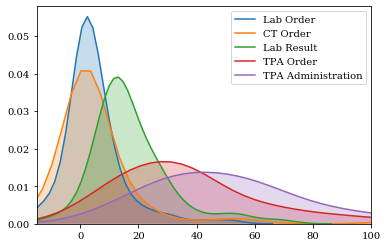

In [10]:

from sklearn.linear_model import LinearRegression as LR
from scipy.stats.stats import pearsonr 
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams.update({'font.size': 10})
plt.rcParams['axes.labelweight'] = 'bold'
import seaborn as sns
import time



sns.kdeplot(T2[:,1], label="Lab Order", shade= True)
sns.kdeplot(T2[:,3], label="CT Order", shade= True)
sns.kdeplot(T2[:,2], label="Lab Result", shade= True)
sns.kdeplot(T2[:,5], label="TPA Order", shade= True)
sns.kdeplot(T2[:,6], label="TPA Administration", shade= True)

#sns.kdeplot(x, bw=.2, label="bw: 0.2")
#sns.kdeplot(x, bw=2, label="bw: 2")
plt.xlim([-15,100])
#plt.ylim()
plt.legend();
plt.show()

### Plot the distribution of access log events around placing an Lab Order

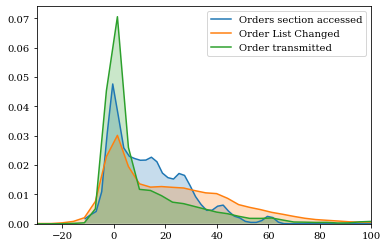

In [27]:
t2LO_mean = np.mean(T2[:,1])
t2LR_mean = np.mean(T2[:,2])
t2CTO_mean = np.mean(T2[:,3])
t2TPA_O_mean = np.mean(T2[:,5])
t2TPA_A_mean = np.mean(T2[:,6])

# Run the query to get
conn = dbapi.connect(client);
cursor = conn.cursor();
query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.LabOrderTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "Order list changed" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();
X1 = np.array(results)

#######

query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.LabOrderTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "Orders section accessed" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X2 = np.array(results)



#########

query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.LabOrderTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "Order Verification Activity accessed" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X3 = np.array(results)


#########

query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.LabOrderTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "Order transmitted" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X4 = np.array(results)



# plot 
sns.kdeplot(X2[:,0], bw=.05, label="Orders section accessed", shade= True)
sns.kdeplot(X1[:,0], bw=.1, label="Order List Changed", shade= True)
#sns.kdeplot(X3[:,0], label="Order Verification Activity accessed", shade= True)
sns.kdeplot(X4[:,0], bw=.1, label="Order transmitted", shade= True)

plt.xlim([-30,100])

plt.show()

In [22]:
### Plot the distribution of access log events around Ordering TPA medication

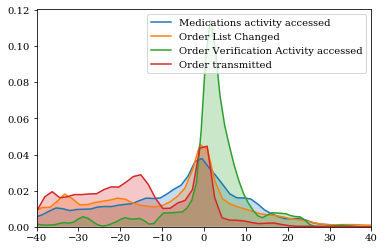

In [36]:
t2LO_mean = np.mean(T2[:,1])
t2LR_mean = np.mean(T2[:,2])
t2CTO_mean = np.mean(T2[:,3])
t2TPA_O_mean = np.mean(T2[:,5])
t2TPA_A_mean = np.mean(T2[:,6])

# Run the query to get
query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.tpaOrderTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "%edication%" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X1 = np.array(results)

#######

query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.tpaOrderTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "Order list changed" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X2 = np.array(results)



#########

query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.tpaOrderTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "Order Verification Activity accessed" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X3 = np.array(results)


#########

query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.tpaOrderTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "Order transmitted" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X4 = np.array(results)


# plot 
sns.kdeplot(X1[:,0], bw=.1, label="Medications activity accessed", shade= True)
sns.kdeplot(X2[:,0], bw=.1, label="Order List Changed", shade= True)
sns.kdeplot(X3[:,0], bw=.1,  label="Order Verification Activity accessed", shade= True)
sns.kdeplot(X4[:,0], bw=.1, label="Order transmitted", shade= True)

plt.xlim([-40,40])

plt.show()

### Plot the distribution of access log events around Lab Result

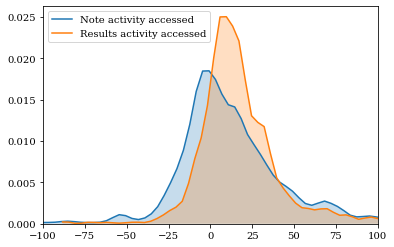

In [41]:
# Run the query to get
query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.LabResultTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "%Note%" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X1 = np.array(results)

#######

query = """ 
SELECT DATETIME_DIFF(AL.access_time_jittered,ET.LabResultTime, MINUTE) as access_time, 
        AL.pat_enc_csn_id_coded, AL.user_deid
FROM noshad.cohort_AL_60 as AL
LEFT JOIN noshad.clinical_event_times as ET Using (pat_enc_csn_id_coded)
WHERE
  AL.access_time_jittered <= AL.tpaAdminTime
AND metric_name LIKE "%Results%" -- "Order list changed" -- "Inpatient Orders section accessed" or "Orders section accessed", "Order transmitted", "Order Verification Activity accessed" "Order Reconciliation Section accessed", "Report viewed for an order"
ORDER BY access_time
"""; 
cursor.execute(query);
results = cursor.fetchall();

X2 = np.array(results)



# plot 
sns.kdeplot(X1[:,0], bw=.1, label="Note activity accessed", shade= True)
sns.kdeplot(X2[:,0], bw=.1, label="Results activity accessed", shade= True)


plt.xlim([-100,100])

plt.show()